ECUACIÓN DE SCHRODINGER DEPENDIENTE DEL TIEMPO: MÉTODO DE CRANCK NICOLSON, INTERFERENCIA DE PAQUETES GAUSSIANOS 1D.

In [1]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import splu
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter  # Para animación y guardar GIF
from matplotlib import animation
from IPython.display import HTML
import matplotlib as mpl


Definición de constantes y parámetros de la simulación.

In [2]:
# Constantes físicas
hbar = 1.0       # constante de Planck reducida
m = 1.0          # masa del electrón

# Parámetros espaciales
x_min, x_max = -15, 15 #límites del dominio, intervalo [x_min,x_max]
N = 5000          # número de puntos espaciales
x = np.linspace(x_min, x_max, N) #discretización del dominio
dx = x[1] - x[0] #paso espacial

# Parámetros temporales
dt = 0.005 #paso temporal 
t_max = 4.0 #tiempo máximo de simulación
Nt = int(t_max / dt) #número de puntos temporales


Definición del potencial y la función de onda inicial

In [3]:
# Definición del potencial (Pozo Infinito)
V = np.zeros(N)        # Inicialmente cero en todo el espacio
V[0] = V[-1] = 1e6     # Bordes “infinitos” para simular condiciones de frontera ψ=0 en los extremos

# Parámetros de los paquetes 
x0_1 = -5.0      # centro del primer paquete (izquierda)
k0_1 = 13.0       # momento hacia la derecha
x0_2 = 5.0       # centro del segundo paquete (derecha)
k0_2 = -13.0      # momento hacia la izquierda
sigma = 0.7      # misma anchura para ambos

# Paquete gaussiano 1 
psi1 = np.exp(-(x-x0_1)**2/(2*sigma**2)) * np.exp(1j * k0_1 * x)

# Paquete gaussiano 2
psi2 = np.exp(-(x-x0_2)**2/(2*sigma**2)) * np.exp(1j * k0_2 * x)

# Combinamos los paquetes
psi0 = psi1 + psi2

# Normalizamos
psi0 /= np.sqrt(np.sum(np.abs(psi0)**2)*dx)


Construcción del Hamiltoniano

In [4]:
# Segunda derivada discreta (operador laplaciano 1D)
main_diag = -2.0 * np.ones(N)
off_diag = 1.0 * np.ones(N-1)
laplacian = diags([off_diag, main_diag, off_diag], [-1,0,1]) / dx**2

# Hamiltoniano H = T + V
H = -(hbar**2 / (2*m)) * laplacian + diags(V, 0)


Construcción Matrices Cranck-Nicolson y Factorización LU de la matriz A

In [5]:
# Matriz identidad
I = diags([np.ones(N)], [0])

# Matrices CN
A = I + 1j*dt/(2*hbar) * H
B = I - 1j*dt/(2*hbar) * H

# Factorización LU de A para resolver sistemas de manera eficiente
A_lu = splu(A.tocsc())


Resolución de la ecuación y comprobamos la conservación de la norma

In [6]:
# Inicializamos la función de onda
psi = psi0.copy()
psi_t = [psi0.copy()]  # Lista para guardar la evolución en el tiempo
                
# Bucle temporal
for n in range(Nt):
    psi = A_lu.solve(B.dot(psi))  # Resolver A ψ^{n+1} = B ψ^n
    psi_t.append(psi.copy())      # Guardar resultado


norms = [np.sum(np.abs(p)**2)*dx for p in psi_t]  # Norma total
times = [n*dt for n in range(len(psi_t))] 

#Imprimimos la norma en cada instante de tiempo
#for t, nrm in zip(times, norms):
    #print(f"t = {t:.4f} -> norma = {nrm:.6f}")


Graficamos la norma en el tiempo

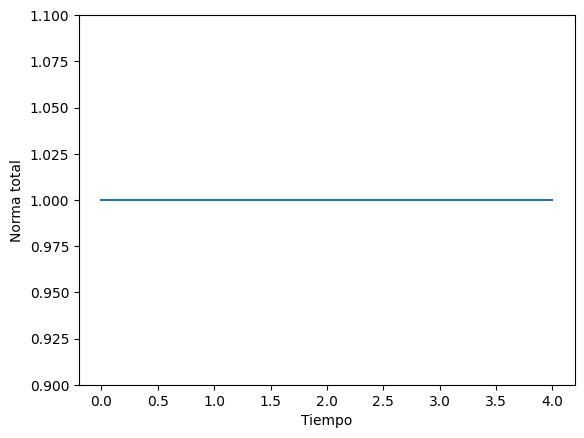

In [7]:
plt.plot(times, norms)
plt.xlabel('Tiempo')
plt.ylabel('Norma total')
plt.ylim([0.9, 1.1])       # Ajusta el rango para resaltar la norma alrededor de 1
plt.ticklabel_format(style='plain')  # Fuerza números “normales”
plt.show()

Generamos la animación para mostrar la evolución de la función de onda en el tiempo

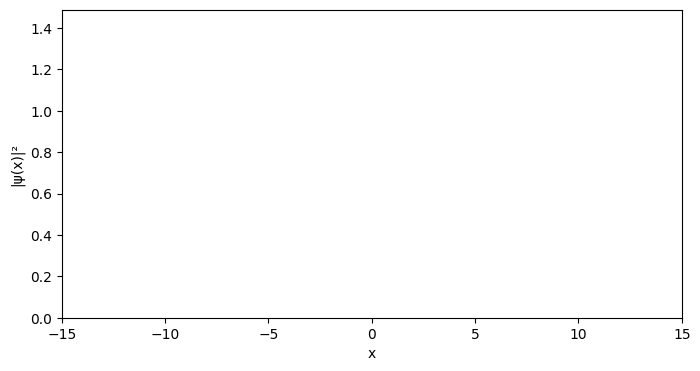

In [8]:
mpl.rcParams['animation.embed_limit'] = 100 * 1024 * 1024  # 100 MB

fig, ax = plt.subplots(figsize=(8, 4))
ln, = ax.plot([], [], 'm-', lw=2)        # Línea que se actualizará (psi)
V_line, = ax.plot([], [], 'k--', lw=2)   # Línea de la barrera
time_text = ax.text(0.65, 0.9, '', transform=ax.transAxes)

ax.set_xlim(x[0], x[-1])
ax.set_ylim(0, np.max([np.abs(p)**2 for p in psi_t])*1.1)
ax.set_xlabel('x')
ax.set_ylabel('|ψ(x)|²')

# Normalizamos la barrera para que se vea junto a |psi|²
V_plot = V / np.max(V) * np.max([np.abs(p)**2 for p in psi_t])

def animate(i):
    ln.set_data(x, np.abs(psi_t[i])**2)  # Actualiza la línea de |psi|²
    V_line.set_data(x, V_plot)            # Actualiza la línea de la barrera
    time_text.set_text(f't = {i*dt:.2f}')
    return ln, V_line, time_text

#ani = animation.FuncAnimation(fig, animate, frames=len(psi_t), interval=20, blit=True)
#HTML(ani.to_jshtml())


Simulación de la densidad de probabilidad junto con la parte real e imaginaria

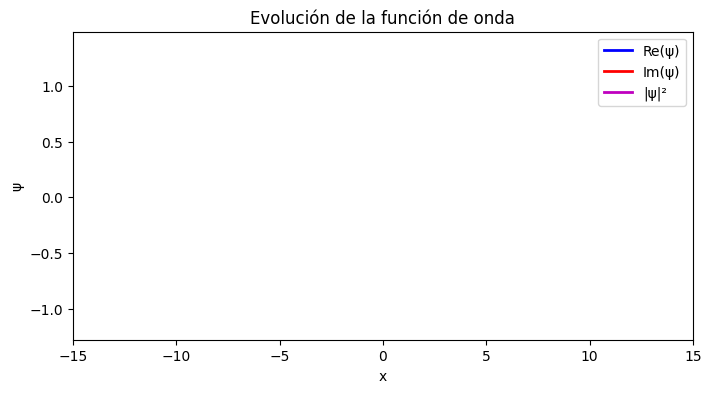

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))

# Tres líneas: real, imaginaria y |ψ|²
ln_real, = ax.plot([], [], 'b-', lw=2, label='Re(ψ)')
ln_imag, = ax.plot([], [], 'r-', lw=2, label='Im(ψ)')
ln_prob, = ax.plot([], [], 'm-', lw=2, label='|ψ|²')
time_text = ax.text(0.65, 0.9, '', transform=ax.transAxes)

ax.set_xlim(x[0], x[-1])
# Aquí hay que pensar bien el eje Y:
max_val = np.max([np.max(np.abs(p)) for p in psi_t])  # máx de Re e Im
max_prob = np.max([np.max(np.abs(p)**2) for p in psi_t])  # máx de |ψ|²
ax.set_ylim(-1.1*max_val, 1.1*max(max_val, max_prob))  

ax.set_xlabel('x')
ax.set_ylabel('ψ')
ax.set_title('Evolución de la función de onda')
ax.legend()
def animate(i):
    psi = psi_t[i]
    ln_real.set_data(x, np.real(psi))
    ln_imag.set_data(x, np.imag(psi))
    ln_prob.set_data(x, np.abs(psi)**2)
    time_text.set_text(f't = {i*dt:.2f}')
    return ln_real, ln_imag, ln_prob, time_text

#ani = animation.FuncAnimation(fig, animate, frames=range(0, len(psi_t), 2),interval=20, blit=True)
#HTML(ani.to_jshtml())


Trayectoria en 3D de la función de onda compleja en cada instante de tiempo

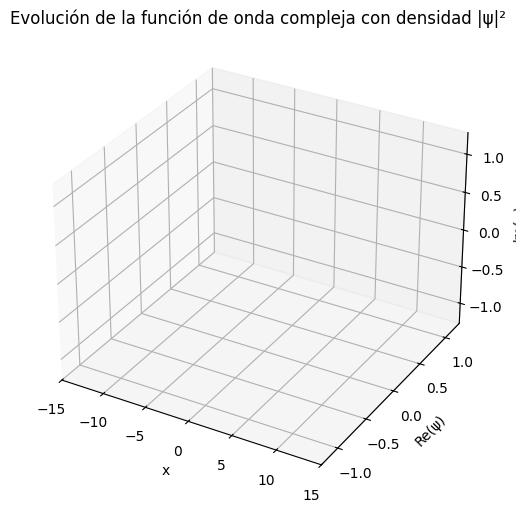

In [10]:
from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.cm as cm

# Crear figura 3D
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('Re(ψ)')
ax.set_zlabel('Im(ψ)')
ax.set_title('Evolución de la función de onda compleja con densidad |ψ|²')

# Límites
max_val = np.max(np.abs(psi_t))
ax.set_xlim(x[0], x[-1])
ax.set_ylim(-1.1*max_val, 1.1*max_val)
ax.set_zlim(-1.1*max_val, 1.1*max_val)

# Normalización de colores
norm = plt.Normalize(0, np.max([np.abs(p)**2 for p in psi_t]))
cmap = cm.plasma

# Inicialización (linea como Line3DCollection)
def init():
    ax.cla()
    return []

# Animación
def animate(i):
    psi = psi_t[i]
    y = np.real(psi)
    z = np.imag(psi)

    # Construir segmentos (cada dos puntos forman un segmento)
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Colorear según |ψ|²
    colors = cmap(norm(np.abs(psi)**2))

    ax.cla()
    ax.set_xlabel('x')
    ax.set_ylabel('Re(ψ)')
    ax.set_zlabel('Im(ψ)')
    ax.set_title(f't = {i*dt:.2f}')
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(-1.1*max_val, 1.1*max_val)
    ax.set_zlim(-1.1*max_val, 1.1*max_val)

    # Crear colección de segmentos
    lc = Line3DCollection(segments, colors=colors[:-1], linewidth=1.5)
    ax.add_collection3d(lc)

    return [lc]

#ani = FuncAnimation(fig, animate, frames=range(0, len(psi_t), 5),init_func=init, blit=False, interval=30)

from IPython.display import HTML
#HTML(ani.to_jshtml())